# 07. PyTorch Transfer Learning

Transfer Learning involves taking the parameters that the model has learned on another dataset and using them on our dataset.

* Pretrained model -> foundation models

Importing the code sections that have been written the the previous notebook.

In [31]:
import matplotlib.pyplot as plt
import torch
import torchvision
from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

In [32]:
# Setup device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## 1. Get data

Using the same pizza, steak, sushi data used in the notebooks before

In [33]:
import os
import zipfile
from pathlib import Path
import requests

#Setup data path
data_path = Path('data/')
image_path = data_path / 'pizza_steak_sushi' # subset from food101 dataset

if image_path.is_dir():
  print(f'{image_path} directory already exists, skipping....')
else:
  print(f'{image_path} not found. Downloading....')
  image_path.mkdir(exist_ok=True, parents=True)

with open(f'{image_path}'+'.zip', 'wb') as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print(f'Downloading dataset at {image_path}','.zip')
  f.write(request.content)

with zipfile.ZipFile(f'{image_path}'+'.zip', 'r') as zipref:
  print('Unzipping the folder')
  zipref.extractall(image_path)

# Remove .zip file
os.remove(f'{image_path}'+'.zip')

data/pizza_steak_sushi directory already exists, skipping....
Unzipping the folder


In [34]:
# Setup directory path
train_dir = image_path / 'train'
test_dir = image_path / 'test'

## 2. Datasets and DataLoaders

We use the `data_setup.py` and it's `create_dataloaders` function

The transforms should depend on the transforms used on the pretrained model

In `torchvision` 0.13+ ways of getting the tranform are:
- manually created transforms - you define what transforms you want your data to go trough
- Automatically created transforms - the transforms for data are defined by the model we use

**Note:** When using a pretrained model, the input data should go through the same transformation as it was trained on

### 2.1 Creating a transform for `torchvision.models` (manual creation)

`torchvision.models` -> pretrained models for training

>


    All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224.

    The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225].

    You can use the following transform to normalize:

    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])


>

IF the model and input data does not match in terms of transforms, the resutls would be subpar at the very least

In [35]:
from torchvision import transforms

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229,0.224,0.225])
manual_transfomrs = transforms.Compose([
    transforms.Resize((224, 224)), # Resize to atleast 224
    transforms.ToTensor(),  # Range from [0,1]
    normalize, # Normalize to specific range
])

In [36]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir, test_dir=test_dir, transform=manual_transfomrs, batch_size=32)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7aa4a04278f0>,
 ['pizza', 'steak', 'sushi'])

### 2.2 Creating a transform for `torchvision.models` (automatically)

As of `trochvision` v0.13+ there is support for automatic data transform creation bassed on the pretrained model weights in use

In [37]:
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [38]:
# Get the transfomrs used to created pretrianed weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [39]:
# Create DataLoaders using automatic transforms
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir,
    test_dir,
    auto_transforms,
    batch_size=32
)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7aa48d056e10>,
 ['pizza', 'steak', 'sushi'])

## 3. Loading in a Pre-trained model

Places to get pretrained models:
- PyTorch domain libraries
- HugginFace Hub
- Paperswithcode
- Libraries like `timm` (only images)

### 3.1 Which pretrained model should you use?

* Experiment, experiment, experiment!*

Take a well performing model from a feature space similar to the custom usecase and then further customize it

Things to consider:
- Speed: How fast to infer
- Size: How big is the model
- Performance: How well does it classify for chosen problem

Where does the model live?
- Server
- Edge compute

Which model should be chosen based on things to consider?

For the usecase of running on the mobile phone, we pick the model like EffecientNet coz the model is small with above avg. metrics.

In ideal case with no restrictions, we would always choose the one with the bes accuracy

### 3.2 Setting up a pretrained model

Want to create an instance of EffNetB0 with pretrained weights

**We will need to change the featuers and the classifier head of the pretrained model we download**

- Features, are feature extractor: which extract subtle features from our images
- avgpool: Compresses all the features found into a single vector of size (in this case 1280) of the input to classifier layer
- classifier: Turn Feature vector into prediction probabilities of each class in the dataset

In [40]:
## OLD method of creating a pre-trained models (prior to torchvision v0.13)
#model = torchvision.models.efficientnet_b0(pretrianed=True)

The old depriciated version error that arrises

```
---------------------------------------------------------------------------

TypeError                                 Traceback (most recent call last)

/tmp/ipython-input-3485331152.py in <cell line: 0>()
      1 ## OLD method of creating a pre-trained models (prior to torchvision v0.13)
----> 2 model = torchvision.models.efficientnet_b0(pretrianed=True)

3 frames

/usr/local/lib/python3.12/dist-packages/torchvision/models/efficientnet.py in _efficientnet(inverted_residual_setting, dropout, last_channel, weights, progress, **kwargs)
    356         _ovewrite_named_param(kwargs, "num_classes", len(weights.meta["categories"]))
    357
--> 358     model = EfficientNet(inverted_residual_setting, dropout, last_channel=last_channel, **kwargs)
    359
    360     if weights is not None:

TypeError: EfficientNet.__init__() got an unexpected keyword argument 'pretrianed'
```

In [51]:
## NEW method of creating a pre-trained model (torchvision v0.13+)
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights).to(device)
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [52]:
model.features

Sequential(
  (0): Conv2dNormActivation(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU(inplace=True)
  )
  (1): Sequential(
    (0): MBConv(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): SiLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (avgpool): AdaptiveAvgPool2d(output_size=1)
          (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (activation): SiLU(inplace=True)
          (scale_activation): Sigmoid()
        )
        (2): Conv2dNormActivation(
          (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), 

In [53]:
model.avgpool

AdaptiveAvgPool2d(output_size=1)

In [54]:
model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

### 3.3 Getting a summary of the model with `torchinfo.summary()`

In [55]:
# Printing summary with torchinfo
from torchinfo import summary

summary(model=model,
        input_size=(1,3,244,244), # batch_size, color_channels, height, width
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20, # Just formatting
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 244, 244]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 244, 244]     [1, 1280, 8, 8]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 244, 244]     [1, 32, 122, 122]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 244, 244]     [1, 32, 122, 122]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 122, 122]    [1, 32, 122, 122]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 122, 122]    [1, 32, 122, 122]    --                   --
│    └─Sequential (1)                                        [1, 32, 122, 122]    [1, 16, 122,

### 3.4 Freezing the base model and changing the output layer to suit our needs

With a feature extractor model, typically you will 'freeze' the base layers of the pretrained/foundation
model and update the output layers to suit the current problem

In [56]:
# Freeze all of the base layers in effNetB0
for param in model.features.parameters():
  param.requires_grad = False
  # print(param)

In [57]:
# Update the classifier head to suit our problem

torch.manual_seed(42)
torch.cuda.manual_seed(42)

model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=len(class_names)), # in_features HAVE TO BE THE SAME AS THE ORIGINAL MODEL
)

In [58]:
summary(model=model,
        input_size=(1,3,244,244), # batch_size, color_channels, height, width
        col_names=['input_size', 'output_size', 'num_params', 'trainable'],
        col_width=20, # Just formatting
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 244, 244]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 244, 244]     [1, 1280, 8, 8]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 244, 244]     [1, 32, 122, 122]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 244, 244]     [1, 32, 122, 122]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 122, 122]    [1, 32, 122, 122]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 122, 122]    [1, 32, 122, 122]    --                   --
│    └─Sequential (1)                                        [1, 32, 122, 122]    [1, 1

## 4. Train model

In [59]:
# Define a loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [60]:
# Import train function
from going_modular.going_modular import engine
from timeit import default_timer as timer

# set manual seeds
torch.cuda.manual_seed(42)
torch.manual_seed(42)

# start timer
start_time = timer()

results = engine.train(
    model=model,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=5,
    device=device
)
# end timer
end_time = timer()

print(f'[INFO] Total training time: {end_time - start_time}')

  0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch: 1 | train_loss: 1.0883 | train_acc: 0.4180 | test_loss: 0.8914 | test_acc: 0.6818
Epoch: 2 | train_loss: 0.9162 | train_acc: 0.6289 | test_loss: 0.8027 | test_acc: 0.7443
Epoch: 3 | train_loss: 0.8162 | train_acc: 0.7031 | test_loss: 0.6787 | test_acc: 0.9072
Epoch: 4 | train_loss: 0.7460 | train_acc: 0.7305 | test_loss: 0.6744 | test_acc: 0.8040
Epoch: 5 | train_loss: 0.6209 | train_acc: 0.7695 | test_loss: 0.6263 | test_acc: 0.8561
[INFO] Total training time: 200.14836146699963


 ## 5. Evaluate model by plotting loss curves

[INFO] helper_funtions.py not found, downloading....


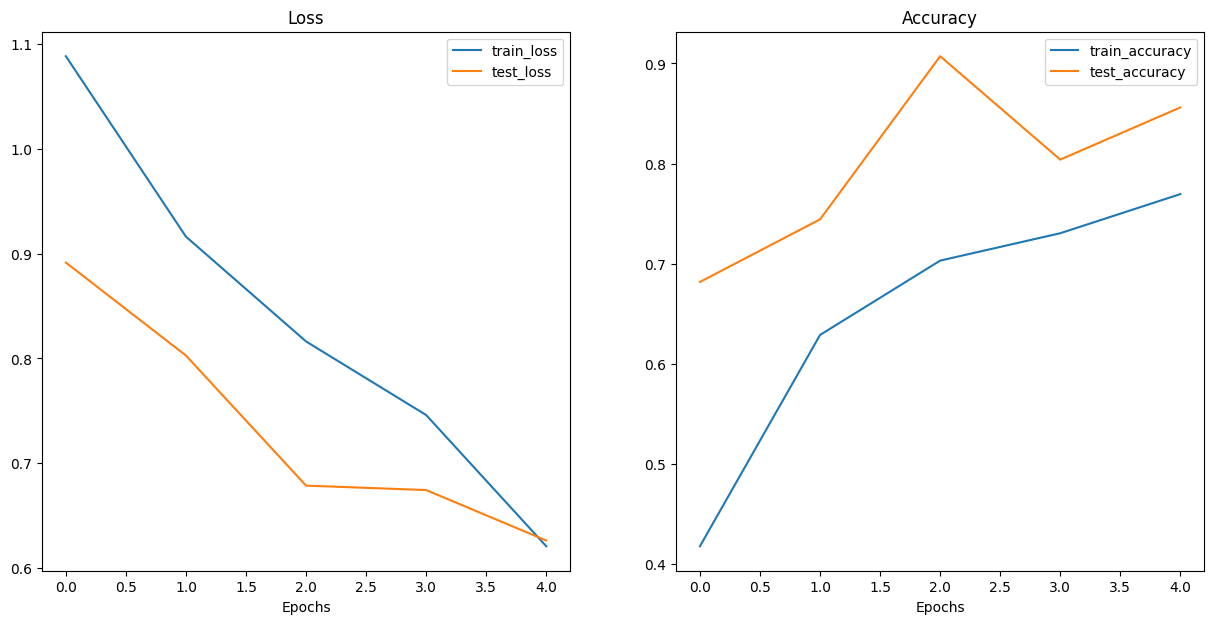

In [61]:
try:
  from helper_funtions import plot_loss_curves
except:
  print(f'[INFO] helper_funtions.py not found, downloading....')
  with open('helper_functions.py', 'wb') as f:
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    f.write(request.content)
  from helper_functions import plot_loss_curves

#Plot the loss curves of the model
plot_loss_curves(results)

## 6. Make predictions on images from the test set

**Visualize, visualize, visualize**

To make qualitative predictions on the test set

Test/custom data have to be:
- Same shape as training images
- Same datatype as the training
- Need to be on the same devie as the model
- Same transforms as the training images the model was trained on

To do all of this automatically we define a new method `pred_and_plot_image()`:

A fucntion similar to the one in notebook 05

1. Take in a trained model, with a list of class names, filepath of infer image, image size, transform, and a target device
2. Open the image with `PIL.Image.open`
3. Create a transform if one does not exist
4. Make sure the model is on the target device
5. Turn the model to `model_eval()` mode to ensure the model is ready for inference
6. Transform the target image and ensure dimensionality is suited the model (including batch size)
7. Predict the class logits
8. Convert output logits to predictions probabilities
9. Convert model's prediction probabilities to prediction labels using `torch.argmax()`
10. Plot the image with `matplotlib` and set the title for the plots

In [70]:
from typing import List, Tuple
from PIL import Image
from torchvision import transforms

# 1. Take in a trained model...
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224,224),
                        transform: torchvision.transforms = None,
                        device: torch.device = device):

  #2. Open image with PIL
  img = Image.open(image_path)

  #3. Create a transform if non-existent
  if transform is not None:
    image_transform = transform
  else:
    image_transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229,0.224,0.225])
    ])

  # 4. Make sure model is on device
  model.to(device)

  # 5. turn on inference mode
  model.eval()

  with torch.inference_mode():
    # 6. transform the image and add extra batch dimention since we only use 1 image and the model expects a batch dimension
    transfomred_image = image_transform(img).unsqueeze(dim=0)

    # 7. Predict to image
    target_image_pred = model(transfomred_image.to(device))

    # 8. Output logits to pred probs
    target_image_pred_probs = target_image_pred.softmax(dim=1)

    # 9. Convert the models pred probs to pred labels
    target_image_pred_label = target_image_pred_probs.argmax(dim=1)

    #10. Plot the image with predicted label and probability
    plt.figure()
    plt.imshow(img)
    plt.title(f'Pred: {class_names[target_image_pred_label]} | Prob {target_image_pred_probs.max():.3f}')
    plt.axis(False)

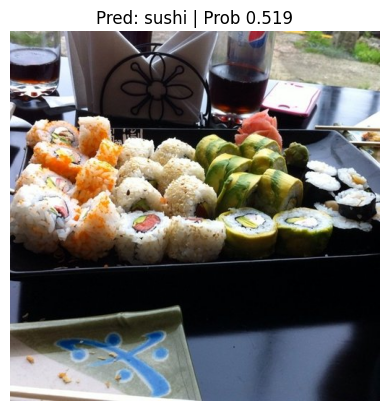

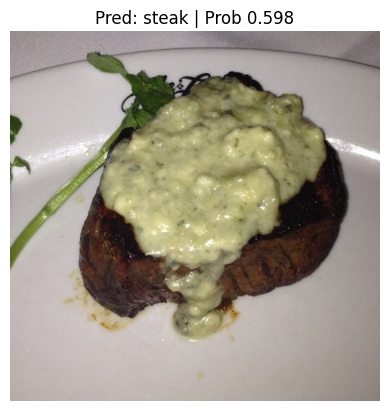

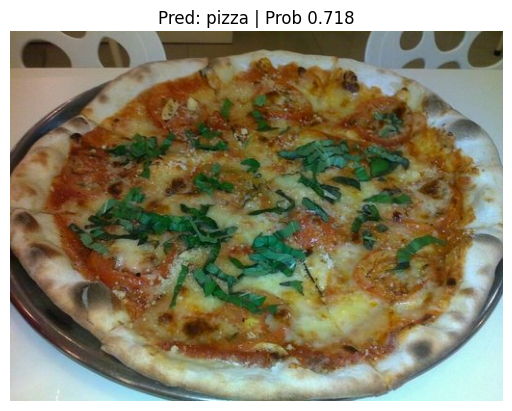

In [73]:
# Get random list of image paths from the test set
import random
num_images = 3

test_image_path_list = list(Path(test_dir).glob('*/*.jpg'))
test_image_path_sample = random.sample(
    population=test_image_path_list,
    k=num_images,
)

# make predictions on and plot the images
for image_path in test_image_path_sample:
  pred_and_plot_image(
      model=model,
      image_path=image_path,
      class_names=class_names,
  )

In [ ]:
### 6.1 Making predictions on a custom image

In [74]:
custom_image = data_path / '04-pizza-dad.jepg'

# download if file is non existant
if not custom_image.is_file():
  print(f'{custom_image} does not exist, downlaoding....')
  with open(custom_image, 'wb') as f:
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
    f.write(request.content)
else:
  print(f'{custom_image} already exists')

data/04-pizza-dad.jepg does not exist, downlaoding....


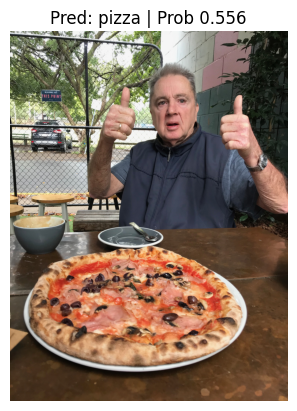

In [75]:
# Predict and plot the image
pred_and_plot_image(
    model,
    custom_image,
    class_names,
)